In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

In [220]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

def divide_time_range(time):
    if time < 600:
        return '00:00~06:00'
    elif time < 1000:
        return '06:00~10:00' # 출근시간
    elif time < 1700:
        return '10:00~17:00'
    elif time < 2100:
        return '17:00~21:00' # 퇴근시간
    else:
        return '21:00~24:00'

def check_best_sarima(data,p,d,q,P,D,Q):
    plot_acf(data)
    plot_pacf(data)
    plt.show()

    model = SARIMAX(data.values, order=(p, d, q), seasonal_order=(P, D, Q, 5))  # 데이터를 넘파이 배열로 변환하여 사용
    model_fit = model.fit()
    print(model_fit.summary())  
    forecast = model_fit.forecast(steps=1)[0]
    
    # 예측 결과 출력
    #print(model_fit.summary())

    return forecast

def sarima_test(data, IDs,p,d,q,P,D,Q,a,b,c):
    result = []
    for 주거_ID in IDs:
        주거_data = data[data['대여소_ID'] == 주거_ID]
        주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
        주거_data.set_index('기준_날짜', inplace=True)
        arima_data = 주거_data.resample('D')['전체_건수'].sum()
        
        forecast = check_best_sarima(arima_data,p,d,q,P,D,Q)
        result.append([주거_ID, forecast,a,b,c])
        
    return result

# 주거_강서_df1 : 대여 ARIMA(4,0,0)(2,1,1)[5] x                주거-대여-출근 
# 주거_강서_df1 : 반납 ARIMA(0,0,0)(2,1,0)[5] x                주거-반납-출근 
# 주거_강서_df2 : 대여 ARIMA(2,0,3)(2,1,0)[5] x                주거-대여-퇴근 
# 주거_강서_df2 : 반납 ARIMA(0,0,1)(2,1,1)[5] x                주거-반납-퇴근 
# 상업_강서_df1 : 대여 ARIMA(4,0,2)(2,1,0)[5] x                상업-대여-출근 ==오류가 생겼음
# 상업_강서_df1 : 반납 ARIMA(3,0,3)(1,1,0)[5] x                상업-반납-출근 
# 상업_강서_df2 : 대여 ARIMA(4,0,2)(2,1,0)[5] x                상업-대여-퇴근 
# 상업_강서_df2 : 반납 ARIMA(4,0,2)(2,1,0)[5] x                상업-반납-퇴근 


# 주거_강서_df1 : 대여 ARIMA(4,1,0)(2,1,0)[5]
# 주거_강서_df1 : 반납 ARIMA(4,1,0)(2,1,0)[5]            ? 
# 주거_강서_df2 : 대여 ARIMA(3,1,0)(2,1,1)[5]   
# 주거_강서_df2 : 반납 ARIMA(4,1,0)(2,1,0)[5] 
# 상업_강서_df1 : 대여 ARIMA(3,1,0)(2,1,0)[5]        df1 : 출근
# 상업_강서_df1 : 반납 ARIMA(3,1,0)(2,1,0)[5] 
# 상업_강서_df2 : 대여 ARIMA(4,1,0)(2,1,0)[5]        df2 : 퇴근
# 상업_강서_df2 : 반납 ARIMA(4,1,0)(2,1,0)[5] 

# 주거 + 대여 + 출근
# 주거_강서_df1 : 대여 ARIMA(4,0,0)(2,1,1)[5]
# 주거_강서_df1 : 대여 ARIMA(4,1,0)(2,1,0)[5]

3385613


C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3872056383.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


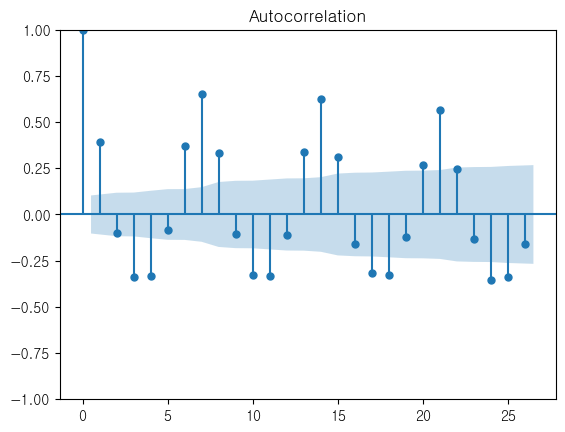

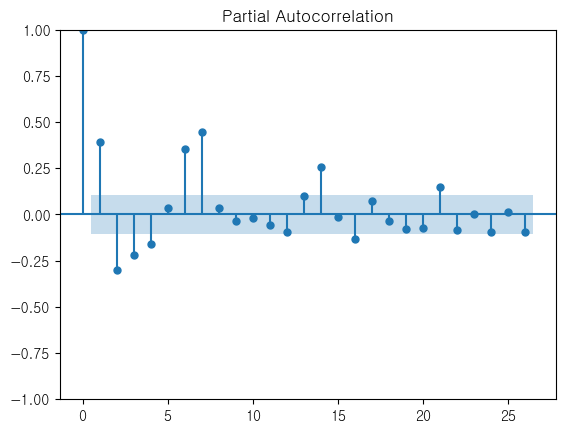

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1722.991
Date:                           Thu, 09 May 2024   AIC                           3459.981
Time:                                   01:47:26   BIC                           3487.106
Sample:                                        0   HQIC                          3470.771
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2863      0.055     -5.212      0.000      -0.394      -0.179
ar.L2         -0.2338      0.054     -4.365

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3872056383.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


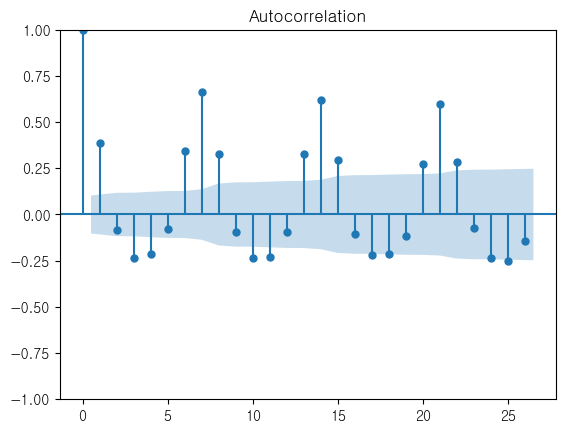

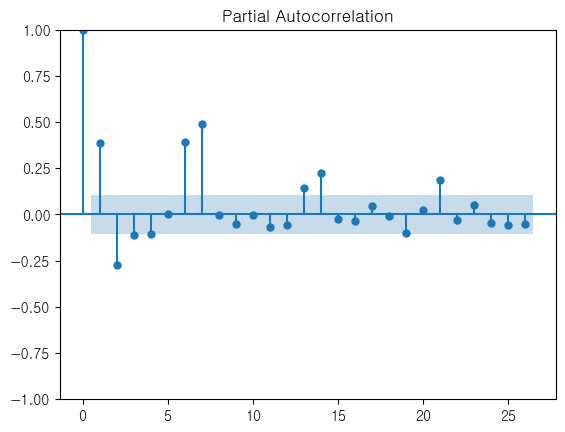

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1748.944
Date:                           Thu, 09 May 2024   AIC                           3511.887
Time:                                   01:47:27   BIC                           3539.012
Sample:                                        0   HQIC                          3522.677
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2962      0.058     -5.121      0.000      -0.410      -0.183
ar.L2         -0.2360      0.048     -4.939

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3872056383.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


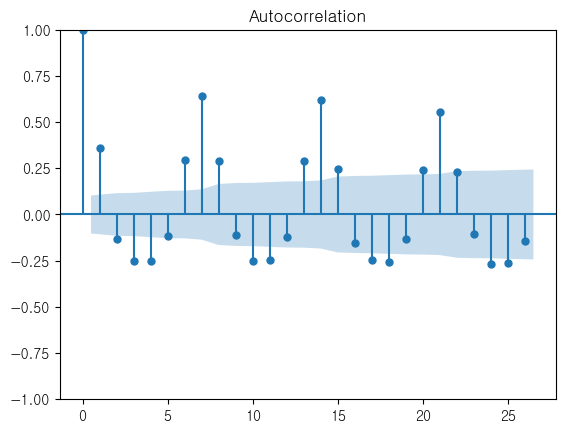

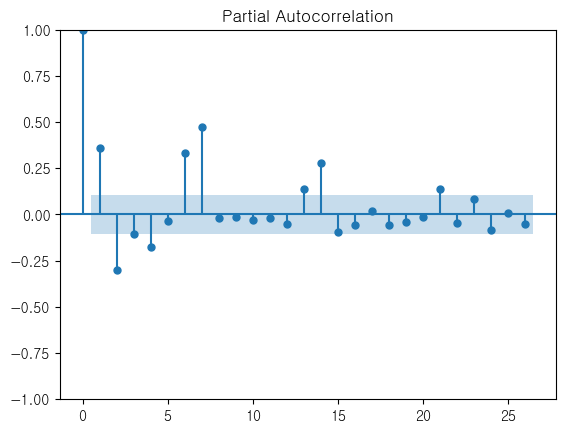

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1788.172
Date:                           Thu, 09 May 2024   AIC                           3590.343
Time:                                   01:47:27   BIC                           3617.468
Sample:                                        0   HQIC                          3601.133
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3141      0.060     -5.205      0.000      -0.432      -0.196
ar.L2         -0.2785      0.052     -5.365

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3872056383.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


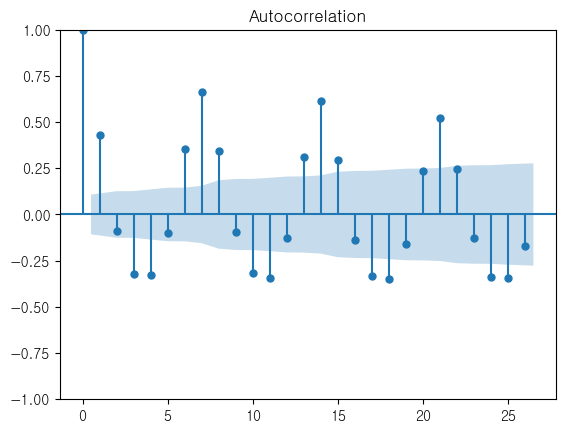

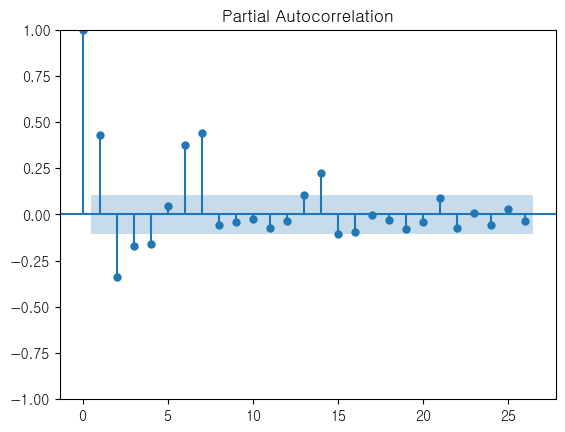

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  332
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1694.149
Date:                           Thu, 09 May 2024   AIC                           3402.298
Time:                                   01:47:28   BIC                           3428.806
Sample:                                        0   HQIC                          3412.876
                                           - 332                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2435      0.059     -4.095      0.000      -0.360      -0.127
ar.L2         -0.2155      0.053     -4.044

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3872056383.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


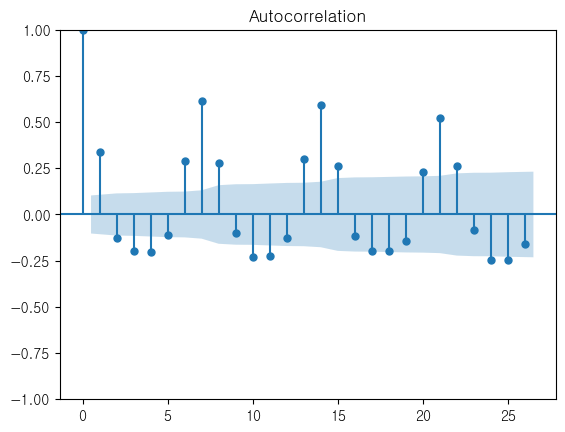

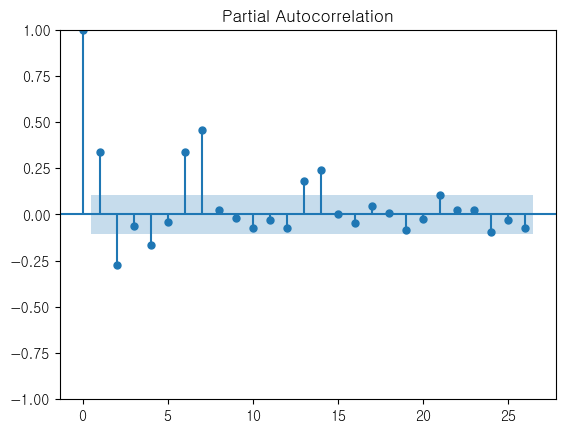

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1772.880
Date:                           Thu, 09 May 2024   AIC                           3559.760
Time:                                   01:47:28   BIC                           3586.884
Sample:                                        0   HQIC                          3570.549
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6140      0.054    -11.361      0.000      -0.720      -0.508
ar.L2         -0.6670      0.062    -10.727

c:\Users\ciw96\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3872056383.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


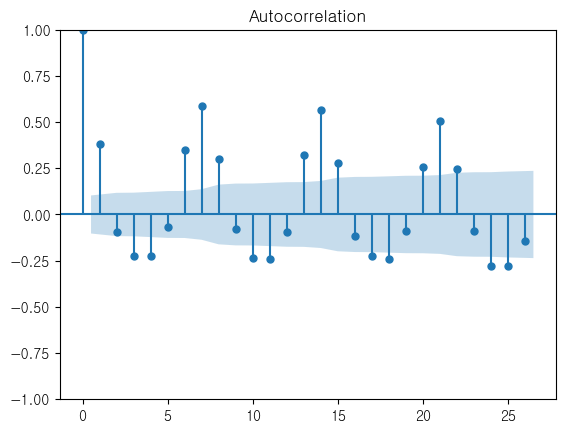

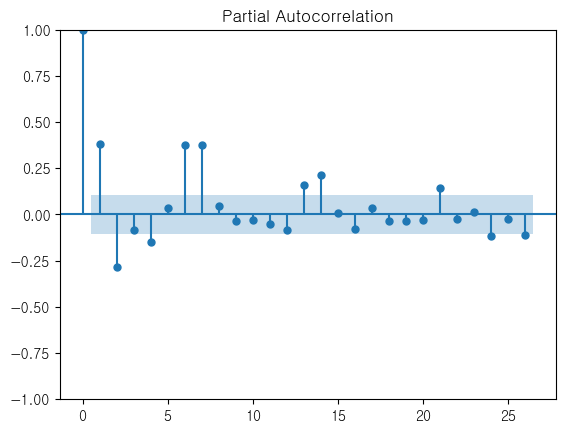

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1865.120
Date:                           Thu, 09 May 2024   AIC                           3744.239
Time:                                   01:47:29   BIC                           3771.364
Sample:                                        0   HQIC                          3755.029
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2667      0.052     -5.090      0.000      -0.369      -0.164
ar.L2         -0.3623      0.049     -7.394

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3872056383.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


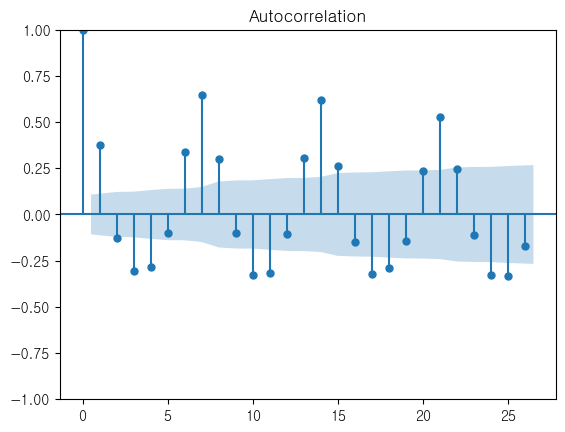

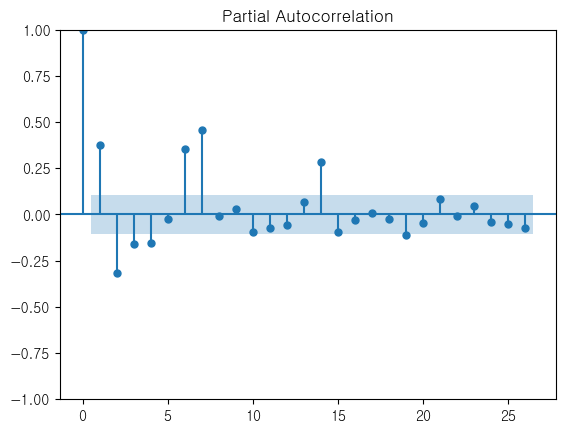

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  332
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1631.034
Date:                           Thu, 09 May 2024   AIC                           3276.067
Time:                                   01:47:29   BIC                           3302.575
Sample:                                        0   HQIC                          3286.645
                                           - 332                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3119      0.061     -5.153      0.000      -0.431      -0.193
ar.L2         -0.2619      0.056     -4.651

In [221]:
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
print(len(강서_데이터))

top_20_ID = pd.read_csv('../../Data/따릉이/쏠림정도_top20_대여소.csv',encoding='utf-8')
# 주거와 상업으로 데이터 분할
주거_df = top_20_ID[top_20_ID['최종용도'] == '주거']
상업_df = top_20_ID[top_20_ID['최종용도'] == '상업']

# 주거 데이터에서 대여소_ID 추출
주거_IDs = 주거_df['대여소_ID'].unique()

# 상업 데이터에서 대여소_ID 추출
상업_IDs = 상업_df['대여소_ID'].unique()

강서_df = 강서_데이터[강서_데이터['시작_대여소_ID'].isin(주거_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '06:00~10:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['시작_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'시작_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납
#check_forcast1 =[]
#check_forcast1.append(sarima_test(강서_df1,주거_IDs,4,1,0,2,1,0,"주거",'06:00~10:00','대여'))
c = []
c = sarima_test(강서_df1,주거_IDs,4,1,0,2,1,0,"주거",'06:00~10:00','대여')


# 주거 반납 출근
# 주거_강서_df1 : 반납 ARIMA(0,0,0)(2,1,0)[5] 
# 주거_강서_df1 : 반납 ARIMA(4,1,0)(2,1,0)[5] 

In [217]:

강서_df = 강서_데이터[강서_데이터['종료_대여소_ID'].isin(주거_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '06:00~10:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['종료_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'종료_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

check_forcast1.append(sarima_test(강서_df1,주거_IDs,4,1,0,2,1,0,"주거",'06:00~10:00','반납'))
print(check_forcast1)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1009.492
Date:                           Thu, 09 May 2024   AIC                           2032.985
Time:                                   01:17:56   BIC                           2060.109
Sample:                                        0   HQIC                          2043.775
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3721      0.057     -6.497      0.000      -0.484      -0.260
ar.L2         -0.4093      0.053     -7.690

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1270.658
Date:                           Thu, 09 May 2024   AIC                           2555.315
Time:                                   01:17:56   BIC                           2582.440
Sample:                                        0   HQIC                          2566.105
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4093      0.057     -7.138      0.000      -0.522      -0.297
ar.L2         -0.2985      0.049     -6.055

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  332
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1011.126
Date:                           Thu, 09 May 2024   AIC                           2036.251
Time:                                   01:17:57   BIC                           2062.760
Sample:                                        0   HQIC                          2046.830
                                           - 332                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4521      0.061     -7.367      0.000      -0.572      -0.332
ar.L2         -0.2701      0.065     -4.150

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1312.666
Date:                           Thu, 09 May 2024   AIC                           2639.333
Time:                                   01:17:57   BIC                           2666.457
Sample:                                        0   HQIC                          2650.122
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3545      0.060     -5.875      0.000      -0.473      -0.236
ar.L2         -0.3194      0.051     -6.304

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1586.838
Date:                           Thu, 09 May 2024   AIC                           3187.677
Time:                                   01:17:57   BIC                           3214.801
Sample:                                        0   HQIC                          3198.466
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2943      0.056     -5.302      0.000      -0.403      -0.186
ar.L2         -0.3244      0.053     -6.111

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  332
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1041.670
Date:                           Thu, 09 May 2024   AIC                           2097.340
Time:                                   01:17:58   BIC                           2123.849
Sample:                                        0   HQIC                          2107.919
                                           - 332                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3387      0.055     -6.158      0.000      -0.446      -0.231
ar.L2         -0.2796      0.056     -4.988

# 주거 + 대여 + 퇴근
# 주거_강서_df2 : 대여 ARIMA(2,0,3)(2,1,0)[5]              ? 
# 주거_강서_df2 : 대여 ARIMA(3,1,0)(2,1,1)[5] 

In [218]:

강서_df = 강서_데이터[강서_데이터['시작_대여소_ID'].isin(주거_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '17:00~21:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['시작_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'시작_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

check_forcast1.append(sarima_test(강서_df1,주거_IDs,3,1,0,2,1,1,"주거",'17:00~21:00','대여'))
print(check_forcast1)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  362
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 5)   Log Likelihood               -1482.528
Date:                             Thu, 09 May 2024   AIC                           2979.056
Time:                                     01:18:19   BIC                           3006.181
Sample:                                          0   HQIC                          2989.846
                                             - 362                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7113      0.053    -13.490      0.000      -0.815      -0.608
ar.L2         -0.6100      

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  362
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 5)   Log Likelihood               -1590.538
Date:                             Thu, 09 May 2024   AIC                           3195.077
Time:                                     01:18:19   BIC                           3222.201
Sample:                                          0   HQIC                          3205.866
                                             - 362                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8253      0.051    -16.224      0.000      -0.925      -0.726
ar.L2         -0.6926      

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  362
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 5)   Log Likelihood               -1484.708
Date:                             Thu, 09 May 2024   AIC                           2983.417
Time:                                     01:18:20   BIC                           3010.541
Sample:                                          0   HQIC                          2994.207
                                             - 362                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7849      0.047    -16.752      0.000      -0.877      -0.693
ar.L2         -0.7192      

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
c:\Users\ciw96\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  333
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 5)   Log Likelihood               -1340.909
Date:                             Thu, 09 May 2024   AIC                           2695.818
Time:                                     01:18:21   BIC                           2722.348
Sample:                                          0   HQIC                          2706.404
                                             - 333                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6849      0.055    -12.429      0.000      -0.793      -0.577
ar.L2         -0.6393      

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  362
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 5)   Log Likelihood               -1726.154
Date:                             Thu, 09 May 2024   AIC                           3466.309
Time:                                     01:18:22   BIC                           3493.433
Sample:                                          0   HQIC                          3477.099
                                             - 362                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6962      0.049    -14.247      0.000      -0.792      -0.600
ar.L2         -0.6685      

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  333
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 5)   Log Likelihood               -1299.661
Date:                             Thu, 09 May 2024   AIC                           2613.322
Time:                                     01:18:23   BIC                           2639.852
Sample:                                          0   HQIC                          2623.908
                                             - 333                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7266      0.051    -14.264      0.000      -0.826      -0.627
ar.L2         -0.6531      

c:\Users\ciw96\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 주거 + 반납 + 퇴근
# 주거_강서_df2 : 반납 ARIMA(0,0,1)(2,1,1)[5]
# 주거_강서_df2 : 반납 ARIMA(4,1,0)(2,1,0)[5] 

In [219]:

강서_df = 강서_데이터[강서_데이터['종료_대여소_ID'].isin(주거_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '17:00~21:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['종료_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'종료_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

check_forcast1.append(sarima_test(강서_df1,주거_IDs,4,1,0,2,1,0,"주거",'17:00~21:00','반납'))
print(check_forcast1)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1743.649
Date:                           Thu, 09 May 2024   AIC                           3501.298
Time:                                   01:18:57   BIC                           3528.423
Sample:                                        0   HQIC                          3512.088
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3520      0.054     -6.517      0.000      -0.458      -0.246
ar.L2         -0.2065      0.045     -4.579

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1829.254
Date:                           Thu, 09 May 2024   AIC                           3672.507
Time:                                   01:18:58   BIC                           3699.632
Sample:                                        0   HQIC                          3683.297
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4388      0.050     -8.820      0.000      -0.536      -0.341
ar.L2         -0.1801      0.040     -4.496

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1781.800
Date:                           Thu, 09 May 2024   AIC                           3577.601
Time:                                   01:18:58   BIC                           3604.725
Sample:                                        0   HQIC                          3588.391
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3305      0.055     -6.035      0.000      -0.438      -0.223
ar.L2         -0.2484      0.043     -5.791

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  333
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1713.627
Date:                           Thu, 09 May 2024   AIC                           3441.255
Time:                                   01:18:59   BIC                           3467.784
Sample:                                        0   HQIC                          3451.840
                                           - 333                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3584      0.057     -6.242      0.000      -0.471      -0.246
ar.L2         -0.2526      0.048     -5.235

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
c:\Users\ciw96\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  362
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1766.765
Date:                           Thu, 09 May 2024   AIC                           3547.530
Time:                                   01:19:00   BIC                           3574.655
Sample:                                        0   HQIC                          3558.320
                                           - 362                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6896      0.052    -13.259      0.000      -0.792      -0.588
ar.L2         -0.6927      0.070     -9.888

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1018408672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  333
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -1577.830
Date:                           Thu, 09 May 2024   AIC                           3169.660
Time:                                   01:19:01   BIC                           3196.190
Sample:                                        0   HQIC                          3180.246
                                           - 333                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6801      0.059    -11.620      0.000      -0.795      -0.565
ar.L2         -0.6928      0.074     -9.412

c:\Users\ciw96\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 상업 + 대여 + 출근
# 상업_강서_df1 : 대여 ARIMA(4,0,2)(2,1,0)[5]
 - 오류생김 3,0,2, 2,1,0, 대체
# 상업_강서_df1 : 대여 ARIMA(3,1,0)(2,1,0)[5] 


In [199]:

강서_df = 강서_데이터[강서_데이터['시작_대여소_ID'].isin(상업_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '06:00~10:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['시작_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'시작_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

check_forcast1.append(sarima_test(강서_df1,상업_IDs,3,1,0,2,1,0,"상업",'06:00~10:00','대여'))
print(check_forcast1)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[[['ST-1253', 56.29384346997406, '주거', '06:00~10:00', '대여'], ['ST-1352', 39.957055266996186, '주거', '06:00~10:00', '대여'], ['ST-1645', 61.01286155907235, '주거', '06:00~10:00', '대여'], ['ST-2050', 58.81137330468149, '주거', '06:00~10:00', '대여'], ['ST-2056', 33.379615675534964, '주거', '06:00~10:00', '대여'], ['ST-2557', 82.83049834591277, '주거', '06:00~10:00', '대여'], ['ST-2965', 59.55757488777407, '주거', '06:00~10:00', '대여']], [['ST-1253', 6.776115161698364, '주거', '06:00~10:00', '반납'], ['ST-1352', 12.852091877392013, '주거', '06:00~10:00', '반납'], ['ST-1645', 5.743580798463418, '주거', '06:00~10:00', '반납'], ['ST-2050', 9.083741740597635, '주거', '06:00~10:00', '반납'], ['ST-2056', 14.001431233298174, '주거', '06:00~10:00', '반납'], ['ST-2557', 36.87565082041742, '주거', '06:00~10:00', '반납'], ['ST-2965', 13.189451965354644, '주거', '06:00~10:00', '반납']], [['ST-1253', 21.12663512659632, '주거', '17:00~21:00', '대여'], ['ST-1352', 14.535426555700395, '주거', '17:00~21:00', '대여'], ['ST-1645', 22.715476039042535, '주거', '17:00

# 상업 + 반납 + 출근
# 상업_강서_df1 : 반납 ARIMA(3,0,3)(1,1,0)[5]        df1 : 출근
# 상업_강서_df1 : 반납 ARIMA(3,1,0)(2,1,0)[5] 


In [200]:

강서_df = 강서_데이터[강서_데이터['종료_대여소_ID'].isin(상업_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '06:00~10:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['종료_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'종료_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

check_forcast1.append(sarima_test(강서_df1,상업_IDs,3,1,0,2,1,0,"상업",'06:00~10:00','반납'))
print(check_forcast1)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[[['ST-1253', 56.29384346997406, '주거', '06:00~10:00', '대여'], ['ST-1352', 39.957055266996186, '주거', '06:00~10:00', '대여'], ['ST-1645', 61.01286155907235, '주거', '06:00~10:00', '대여'], ['ST-2050', 58.81137330468149, '주거', '06:00~10:00', '대여'], ['ST-2056', 33.379615675534964, '주거', '06:00~10:00', '대여'], ['ST-2557', 82.83049834591277, '주거', '06:00~10:00', '대여'], ['ST-2965', 59.55757488777407, '주거', '06:00~10:00', '대여']], [['ST-1253', 6.776115161698364, '주거', '06:00~10:00', '반납'], ['ST-1352', 12.852091877392013, '주거', '06:00~10:00', '반납'], ['ST-1645', 5.743580798463418, '주거', '06:00~10:00', '반납'], ['ST-2050', 9.083741740597635, '주거', '06:00~10:00', '반납'], ['ST-2056', 14.001431233298174, '주거', '06:00~10:00', '반납'], ['ST-2557', 36.87565082041742, '주거', '06:00~10:00', '반납'], ['ST-2965', 13.189451965354644, '주거', '06:00~10:00', '반납']], [['ST-1253', 21.12663512659632, '주거', '17:00~21:00', '대여'], ['ST-1352', 14.535426555700395, '주거', '17:00~21:00', '대여'], ['ST-1645', 22.715476039042535, '주거', '17:00

# 상업 + 대여 + 퇴근
# 상업_강서_df2 : 대여 ARIMA(4,0,2)(2,1,0)[5]
# 상업_강서_df2 : 대여 ARIMA(4,1,0)(2,1,0)[5] 

In [201]:

강서_df = 강서_데이터[강서_데이터['시작_대여소_ID'].isin(상업_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '17:00~21:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['시작_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'시작_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

check_forcast1.append(sarima_test(강서_df1,상업_IDs,4,1,0,2,1,0,"상업",'17:00~21:00','대여'))
print(check_forcast1)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[[['ST-1253', 56.29384346997406, '주거', '06:00~10:00', '대여'], ['ST-1352', 39.957055266996186, '주거', '06:00~10:00', '대여'], ['ST-1645', 61.01286155907235, '주거', '06:00~10:00', '대여'], ['ST-2050', 58.81137330468149, '주거', '06:00~10:00', '대여'], ['ST-2056', 33.379615675534964, '주거', '06:00~10:00', '대여'], ['ST-2557', 82.83049834591277, '주거', '06:00~10:00', '대여'], ['ST-2965', 59.55757488777407, '주거', '06:00~10:00', '대여']], [['ST-1253', 6.776115161698364, '주거', '06:00~10:00', '반납'], ['ST-1352', 12.852091877392013, '주거', '06:00~10:00', '반납'], ['ST-1645', 5.743580798463418, '주거', '06:00~10:00', '반납'], ['ST-2050', 9.083741740597635, '주거', '06:00~10:00', '반납'], ['ST-2056', 14.001431233298174, '주거', '06:00~10:00', '반납'], ['ST-2557', 36.87565082041742, '주거', '06:00~10:00', '반납'], ['ST-2965', 13.189451965354644, '주거', '06:00~10:00', '반납']], [['ST-1253', 21.12663512659632, '주거', '17:00~21:00', '대여'], ['ST-1352', 14.535426555700395, '주거', '17:00~21:00', '대여'], ['ST-1645', 22.715476039042535, '주거', '17:00

# 상업 + 반납 + 퇴근
# 상업_강서_df2 : 반납 ARIMA(4,0,2)(2,1,0)[5]       df2 : 퇴근
# 상업_강서_df2 : 반납 ARIMA(4,1,0)(2,1,0)[5] 

In [202]:

강서_df = 강서_데이터[강서_데이터['종료_대여소_ID'].isin(상업_IDs)] # 시작 : 대여 ,종료 : 반납   + 주거, 상업
강서_df = 강서_df.sort_values(by='기준_날짜')

강서_df['시간대_구간'] = 강서_df['기준_시간대'].apply(divide_time_range)
강서_df1 = 강서_df[강서_df['시간대_구간'] == '17:00~21:00']     # 06~10 : , 17:21 :퇴근
강서_df1 = 강서_df1[(강서_df1['전체_이용_분'] != 0) & (강서_df1['전체_이용_거리'] != 0)]

강서_df1 = 강서_df1[['종료_대여소_ID', '기준_날짜', '전체_건수']].copy() # 시작 : 대여 ,종료 : 반납
강서_df1 = 강서_df1.rename(columns={'종료_대여소_ID': '대여소_ID'})     # 시작 : 대여 ,종료 : 반납

check_forcast1.append(sarima_test(강서_df1,상업_IDs,4,1,0,2,1,0,"상업",'17:00~21:00','반납'))
print(check_forcast1)

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\1426897358.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[[['ST-1253', 56.29384346997406, '주거', '06:00~10:00', '대여'], ['ST-1352', 39.957055266996186, '주거', '06:00~10:00', '대여'], ['ST-1645', 61.01286155907235, '주거', '06:00~10:00', '대여'], ['ST-2050', 58.81137330468149, '주거', '06:00~10:00', '대여'], ['ST-2056', 33.379615675534964, '주거', '06:00~10:00', '대여'], ['ST-2557', 82.83049834591277, '주거', '06:00~10:00', '대여'], ['ST-2965', 59.55757488777407, '주거', '06:00~10:00', '대여']], [['ST-1253', 6.776115161698364, '주거', '06:00~10:00', '반납'], ['ST-1352', 12.852091877392013, '주거', '06:00~10:00', '반납'], ['ST-1645', 5.743580798463418, '주거', '06:00~10:00', '반납'], ['ST-2050', 9.083741740597635, '주거', '06:00~10:00', '반납'], ['ST-2056', 14.001431233298174, '주거', '06:00~10:00', '반납'], ['ST-2557', 36.87565082041742, '주거', '06:00~10:00', '반납'], ['ST-2965', 13.189451965354644, '주거', '06:00~10:00', '반납']], [['ST-1253', 21.12663512659632, '주거', '17:00~21:00', '대여'], ['ST-1352', 14.535426555700395, '주거', '17:00~21:00', '대여'], ['ST-1645', 22.715476039042535, '주거', '17:00

In [186]:
check1 = pd.read_csv('tpss_bcycl_od_statnhm_20240401.csv',encoding='cp949')

check1 = check1[check1['집계_기준'] != '도착시간']
check1 = check1[(check1['전체_이용_분'] != 0) & (check1['전체_이용_거리'] != 0)]
    
check1['시간대_구간'] = check1['기준_시간대'].apply(divide_time_range)

check = []
check2 = check1[check1['시간대_구간'] == '06:00~10:00']

for 주거_ID in 주거_IDs:
    check.append(check2[check2['시작_대여소_ID']==주거_ID]['전체_건수'].sum())

for 주거_ID in 주거_IDs:
    check.append(check2[check2['종료_대여소_ID']==주거_ID]['전체_건수'].sum())
 
check2 = check1[check1['시간대_구간'] == '17:00~21:00']

for 주거_ID in 주거_IDs:
    check.append(check2[check2['시작_대여소_ID']==주거_ID]['전체_건수'].sum())

for 주거_ID in 주거_IDs:
    check.append(check2[check2['종료_대여소_ID']==주거_ID]['전체_건수'].sum())
 
check2 = check1[check1['시간대_구간'] == '06:00~10:00']

for 주거_ID in 상업_IDs:
    check.append(check2[check2['시작_대여소_ID']==주거_ID]['전체_건수'].sum())

for 주거_ID in 상업_IDs:
    check.append(check2[check2['종료_대여소_ID']==주거_ID]['전체_건수'].sum())
 
check2 = check1[check1['시간대_구간'] == '17:00~21:00']

for 주거_ID in 상업_IDs:
    check.append(check2[check2['시작_대여소_ID']==주거_ID]['전체_건수'].sum())
    
for 주거_ID in 상업_IDs:
    check.append(check2[check2['종료_대여소_ID']==주거_ID]['전체_건수'].sum())
 

In [203]:
# DataFrame으로 변환
df_list = []
for sublist in check_forcast1:
    for item in sublist:
        df_list.append(item)

df = pd.DataFrame(df_list, columns=['대여소_ID', '예측값', '지구', '시간대_구간', '출퇴'])
df['실제 값'] = check

df[df['지구']=='주거']

,대여소_ID,예측값,지구,시간대_구간,출퇴,실제 값
0,ST-1253,56.293843,주거,06:00~10:00,대여,32
1,ST-1352,39.957055,주거,06:00~10:00,대여,56
2,ST-1645,61.012862,주거,06:00~10:00,대여,54
3,ST-2050,58.811373,주거,06:00~10:00,대여,52
4,ST-2056,33.379616,주거,06:00~10:00,대여,34
5,ST-2557,82.830498,주거,06:00~10:00,대여,53
6,ST-2965,59.557575,주거,06:00~10:00,대여,54
7,ST-1253,6.776115,주거,06:00~10:00,반납,3
8,ST-1352,12.852092,주거,06:00~10:00,반납,13
9,ST-1645,5.743581,주거,06:00~10:00,반납,8


In [206]:
# DataFrame으로 변환
df_list1 = []
for sublist in check_forcast:
    for item in sublist:
        df_list1.append(item)

df1 = pd.DataFrame(df_list1, columns=['대여소_ID', '예측값', '지구', '시간대_구간', '출퇴'])
df1['실제 값'] = check


In [207]:
df # d=1

,대여소_ID,예측값,지구,시간대_구간,출퇴,실제 값
0,ST-1253,56.293843,주거,06:00~10:00,대여,32
1,ST-1352,39.957055,주거,06:00~10:00,대여,56
2,ST-1645,61.012862,주거,06:00~10:00,대여,54
3,ST-2050,58.811373,주거,06:00~10:00,대여,52
4,ST-2056,33.379616,주거,06:00~10:00,대여,34
...,...,...,...,...,...,...
75,ST-2871,18.121891,상업,17:00~21:00,반납,53
76,ST-2945,18.161601,상업,17:00~21:00,반납,22
77,ST-3094,22.000821,상업,17:00~21:00,반납,51
78,ST-3128,2.572052,상업,17:00~21:00,반납,5


In [227]:
new_df = df1.groupby(['대여소_ID', '지구', '시간대_구간']).apply(lambda x: x.loc[x['출퇴'] == '대여', '예측값'].values - x.loc[x['출퇴'] == '반납', '예측값'].values).reset_index()
new_df.columns = ['대여소_ID', '지구', '시간대_구간', '예측_자전거_이동량']

real_difference = df1.groupby(['대여소_ID', '지구', '시간대_구간']).apply(lambda x: x.loc[x['출퇴'] == '대여', '실제 값'].values - x.loc[x['출퇴'] == '반납', '실제 값'].values).reset_index()
real_difference.columns = ['대여소_ID', '지구', '시간대_구간', '실제_자전거_이동량']

# 새로운 데이터프레임에 실제값의 차이 열을 추가합니다.
new_df['실제_자전거_이동량'] = real_difference['실제_자전거_이동량']

C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3375238797.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = df1.groupby(['대여소_ID', '지구', '시간대_구간']).apply(lambda x: x.loc[x['출퇴'] == '대여', '예측값'].values - x.loc[x['출퇴'] == '반납', '예측값'].values).reset_index()
C:\Users\ciw96\AppData\Local\Temp\ipykernel_54832\3375238797.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  real_difference = df1.groupb

In [228]:
new_df

,대여소_ID,지구,시간대_구간,예측_자전거_이동량,실제_자전거_이동량
0,ST-1064,상업,06:00~10:00,[-22.961291293145415],[-31]
1,ST-1064,상업,17:00~21:00,[9.188406755756255],[20]
2,ST-1253,주거,06:00~10:00,[36.24608039200826],[29]
3,ST-1253,주거,17:00~21:00,[-20.430953248883256],[-30]
4,ST-1352,주거,06:00~10:00,[32.84850692387765],[43]
5,ST-1352,주거,17:00~21:00,[-11.07057940966692],[-26]
6,ST-1645,주거,06:00~10:00,[24.735319311381602],[46]
7,ST-1645,주거,17:00~21:00,[-17.7097109554814],[-36]
8,ST-1688,상업,06:00~10:00,[-26.141575913346962],[-44]
9,ST-1688,상업,17:00~21:00,[16.250650667968394],[33]
